In [1]:
import pickle
import matplotlib.pyplot as plt
from geometry_msgs.msg import Pose, PoseStamped
from src.ur10e_custom_control.ur10e_custom_control.ur_exercise_qt import Exercise
import transforms3d
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from geometry_msgs.msg import Vector3, Quaternion
from dataclasses import asdict

In [2]:
PATH = "push.exercise"

In [3]:
with open(PATH, "rb") as fp:
    mock_exercise: Exercise = Exercise(**pickle.load(fp))

In [4]:
def extract_positions_orientations(poses: list[PoseStamped], decimation: int = 1):
    x_vals, y_vals, z_vals = [], [], []
    frames = []  # Store coordinate frame data
    
    for i in range(len(poses)):
        if i % decimation != 0:
            continue
        # Extract position
        x_vals.append(poses[i].pose.position.x)
        y_vals.append(poses[i].pose.position.y)
        z_vals.append(poses[i].pose.position.z)

        # Convert quaternion to rotation matrix
        quat = [poses[i].pose.orientation.x, poses[i].pose.orientation.y, poses[i].pose.orientation.z, poses[i].pose.orientation.w]
        rot_matrix = transforms3d.quaternions.quat2mat(quat)[:3, :3]  # Extract 3x3 rotation
        
        frames.append((poses[i].pose.position.x, poses[i].pose.position.y, poses[i].pose.position.z, rot_matrix))
    
    return x_vals, y_vals, z_vals, frames


In [5]:
x_vals, y_vals, z_vals, frames = extract_positions_orientations(mock_exercise.poses)

In [6]:
# Plot 3D Visualization
%matplotlib inline
def plot_3d(x_vals, y_vals, z_vals, frames):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_vals, y_vals, z_vals, color='blue', label="Positions")

    # Plot frames (X, Y, Z axes)
    frame_scale = 0.01
    for x, y, z, rot_matrix in frames:
        for i, color in enumerate(['r', 'g', 'b']):  # X (red), Y (green), Z (blue)
            ax.quiver(x, y, z, 
                    rot_matrix[0, i] * frame_scale, 
                    rot_matrix[1, i] * frame_scale, 
                    rot_matrix[2, i] * frame_scale, 
                    color=color)

    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.set_zlabel("Z Position")
    # Function to set equal axes in 3D
    def set_axes_equal(ax):
        """Set equal scale for all axes in a 3D plot."""
        limits = np.array([ax.get_xlim(), ax.get_ylim(), ax.get_zlim()])
        span = limits[:,1] - limits[:,0]
        center = np.mean(limits, axis=1)
        radius = 0.5 * max(span)
        ax.set_xlim(center[0] - radius, center[0] + radius)
        ax.set_ylim(center[1] - radius, center[1] + radius)
        ax.set_zlim(center[2] - radius, center[2] + radius)

    # Apply equal axes
    set_axes_equal(ax)
    ax.set_title("3D Pose Visualization")
    ax.legend()

In [7]:
def transform_poses(poses: list[PoseStamped], decimation: int = 1) -> list[PoseStamped]:
    transformed_poses = []
    headers = [pose.header for pose in poses]
    for i in range(len(poses)):
        if i % decimation == 0 and i != 0:
            t1 = poses[i-decimation].pose
            t2 = poses[i].pose

            y = np.array([0, -1, 0])

            v = np.array([
                t2.position.x - t1.position.x,
                t2.position.y - t1.position.y,
                t2.position.z - t1.position.z
            ])

            z = v / np.linalg.norm(v)

            # TODO(george): why does this work...
            x = np.cross(y, z) / np.linalg.norm(np.cross(y, z))
            q_new = transforms3d.quaternions.mat2quat(
                np.array([x.T, y.T, z.T]) @ transforms3d.quaternions.quat2mat(
                    [t1.orientation.x, t1.orientation.y, t1.orientation.z, t1.orientation.w]
                )
            )
            
            transformed_poses.append(
                PoseStamped(
                    pose = Pose(
                        position = t1.position,
                        orientation = Quaternion(w=q_new[3], x=q_new[0], y=q_new[1], z=q_new[2])
                    ),
                    header = headers[i]
                )
            )

    transformed_poses.append(poses[-1])
    return transformed_poses

In [8]:
def get_trajectory(poses: list[PoseStamped], distance_threshold: float = 10/1000):
    def dist3d(_t1: PoseStamped, _t2: PoseStamped) -> float:
        return ((_t1.pose.position.x-_t2.pose.position.x)**2 + \
                (_t1.pose.position.y-_t2.pose.position.y)**2 + \
                (_t1.pose.position.z-_t2.pose.position.z)**2)**0.5
    
    last_pose: PoseStamped = poses[0]
    trajectory = [] # Do not include initial pose in the trajectory
    for pose in poses:
        if dist3d(last_pose, pose) >= distance_threshold:
            last_pose = pose
            trajectory.append(pose)

    return trajectory

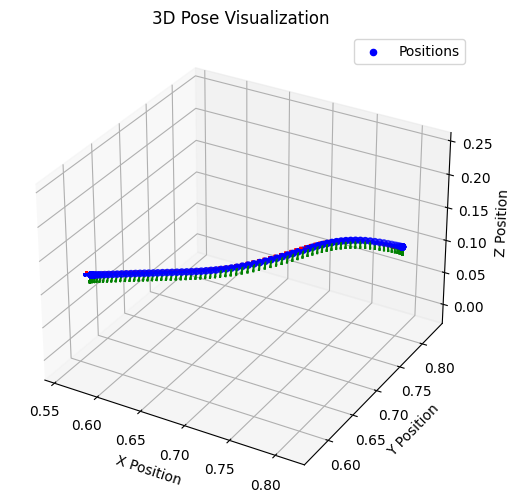

In [9]:
%matplotlib inline
plot_3d(*extract_positions_orientations(mock_exercise.poses, decimation = 1))

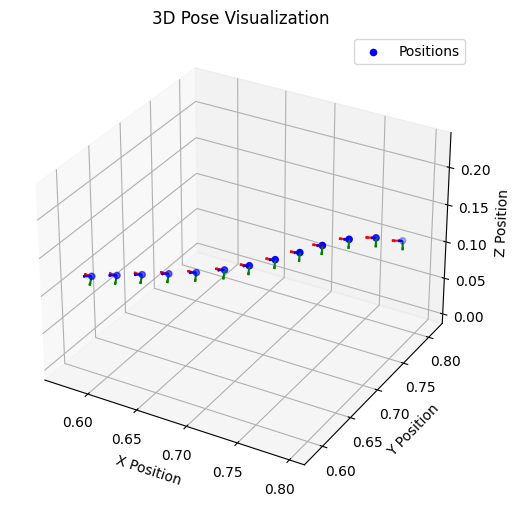

In [10]:
%matplotlib inline
plot_3d(*extract_positions_orientations(get_trajectory(mock_exercise.poses, distance_threshold=20/1000)))

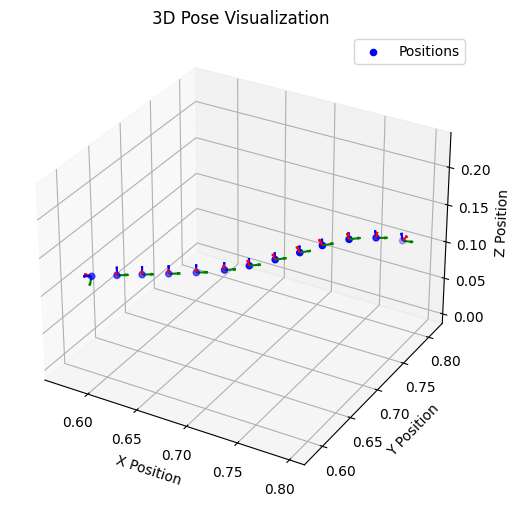

In [11]:
%matplotlib inline
plot_3d(*extract_positions_orientations(transform_poses(get_trajectory(mock_exercise.poses, distance_threshold=20/1000))))

In [12]:
# plot_3d(*extract_positions_orientations(transform_poses(mock_exercise.poses, decimation = 1)[100:-100]))
# plot_3d(*extract_positions_orientations(transform_poses(mock_exercise.poses, decimation = 10)[10:-10]))

In [13]:
modified_exercise = Exercise(
    name = mock_exercise.name,
    poses = get_trajectory(mock_exercise.poses),
    joint_angles = mock_exercise.joint_angles,
    duration = mock_exercise.duration
)

In [14]:
with open("modified_" + PATH, "wb") as fp:
    pickle.dump(asdict(modified_exercise), fp)